In [29]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
import pandas as pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_8228\3980968752.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [30]:
# create gaussian blurs with different widths

nPerClass = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# the two widths (a.u.)
widths = [1.8, 2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2) # ro = random offset
    G = np.exp( -( ( X-ro[0])**2 + (Y-ro[1])**2 ) / (2*widths[i%2]**2) )

    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i%2

labels = labels[:, None]

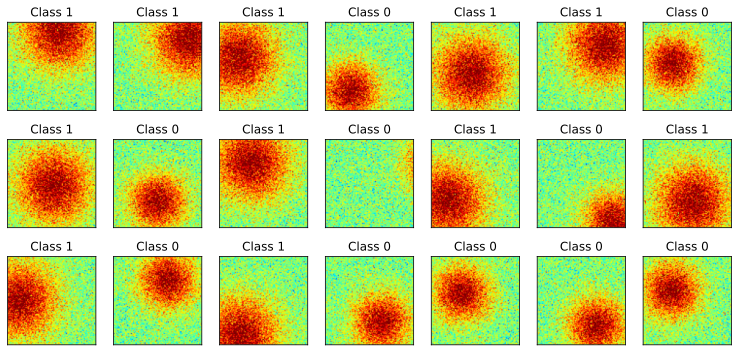

In [31]:
# visualize some images
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichpic, :, :]) # np.squeeze() removes all dimensions of size 1 (grayscale column in this case)
    ax.imshow(G, vmin = -1, vmax = 1, cmap = "jet")
    ax.set_title('Class %s' %int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [32]:
# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [33]:
# check size (should be images X channels X width X height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [34]:
# create a class for the model
def makeTheNet():
    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # all layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding = 1), # output size: (91 + 2*1 - 3)/1 + 1 = 91
                nn.ReLU(), # note that relu is treated like a 'layer'
                nn.AvgPool2d(2, 2), # output size: 91/2 = 45
                nn.Conv2d(6, 4, 3, padding = 1), # output size: (45 + 2*1 - 3)/1 + 1 = 45
                nn.ReLU(), # note that relu is treated like a 'layer'
                nn.AvgPool2d(2, 2), # output size: 45/2 = 22
                nn.Flatten(), # vectorize conv output
                nn.Linear(22*22*4, 50), # output size: 50
                nn.Linear(50, 1), # output size = 1
            )

        def forward(self, x):
            return self.enc(x)

    # create the model instance
    net = gausnet()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [35]:
# test the model with one batch
net, lossfun, optimizer = makeTheNet()

X, y = next(iter(train_loader))
yHat = net(X)

# check the output
print('')
print(yHat.shape)

# now let's compute the loss
loss = lossfun(yHat, y)
print('')
print('Loss:')
print(loss)


torch.Size([32, 1])

Loss:
tensor(0.6957, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [36]:
# count the total number of parameters in the model
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [39]:
# a function that trains the model

def trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(( (yHat > .5) == y).float()).item())
        # end loop
            
        # now that we've trained through the batches, get avg training accuracy
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100*np.mean(batchAcc)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat, y)

        # compute test accuracy
        testLoss[epochi] = loss.item()
        testAcc[epochi] = 100*torch.mean(( (yHat > 0) == y).float()).item()
    # end epochs
    
    # function output
    return trainLoss, testLoss, trainAcc, testAcc, net

In [40]:
trainLoss, testLoss, trainAcc, testAcc, net = trainTheModel()

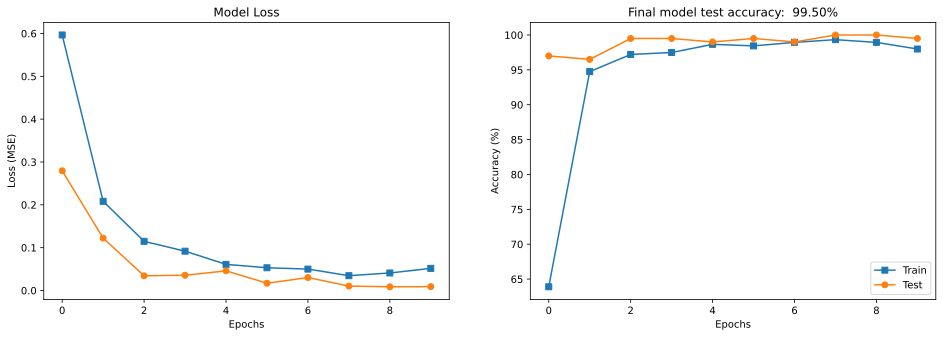

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(trainLoss, 's-', label = 'Train')
ax[0].plot(testLoss, 'o-', label = 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label = 'Train')
ax[1].plot(testAcc, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]: .2f}%')
ax[1].legend()

plt.show()

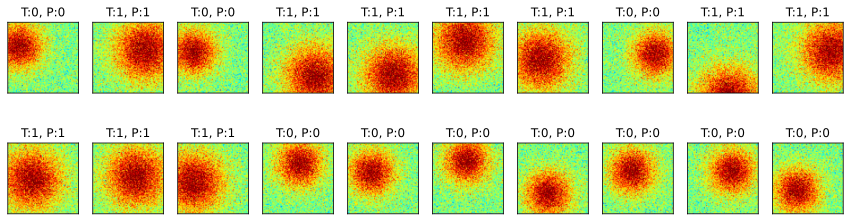

In [43]:
# visualize some images

X,y = next(iter(test_loader))
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach() # X[i,0,:,:] -> [91, 91]
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [44]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print('')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


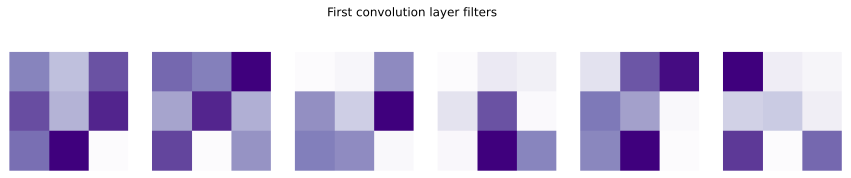

In [45]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

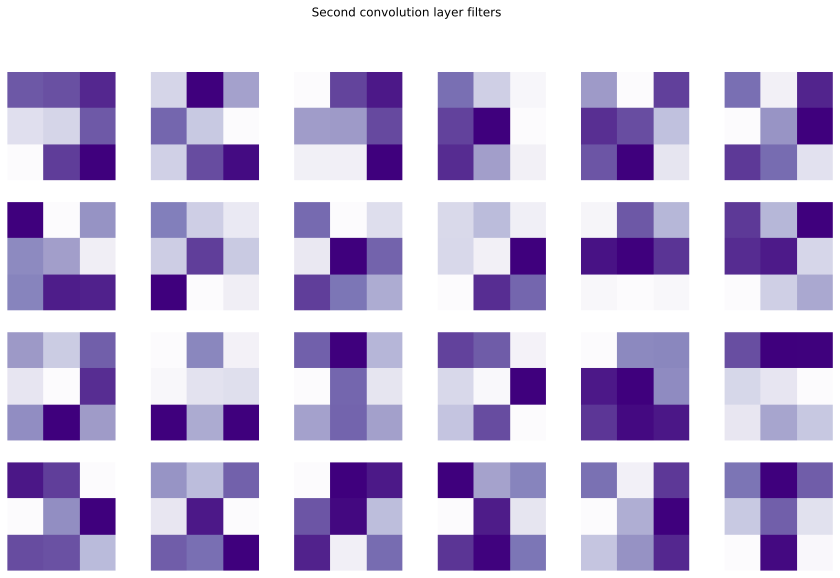

In [46]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()